In [1]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import os
import sys
import pandas as pd
import pickle
import numpy as np

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from batch_sv_system import get_embeds, cosine_sim, compute_plda_score
from utils import key2df, df2dict, compute_eer, get_id2idx
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support

In [310]:
from utils import key2df

embed_dir = "embeddings/voxc2_fbank64_voxc2untied_xvector/"
si_embeds = np.load(embed_dir+"ln_lda_si_embeds.npy")
sv_embeds = np.load(embed_dir+"ln_lda_sv_embeds.npy")
si_keys = pickle.load(open(embed_dir + "/si_keys.pkl", "rb"))
sv_keys = pickle.load(open(embed_dir + "/sv_keys.pkl", "rb"))
sv_id2idx = get_id2idx(sv_keys)
si_df = key2df(si_keys)

cohort_ids = np.load("trials/dev940_eval311/dev_cohort_ids.npy")
cohort_embeds = get_embeds(cohort_ids, sv_embeds, sv_id2idx, norm=False)

In [406]:
from ioffe_plda.verifier import Verifier
py_plda_model = Verifier()
py_plda_model = Verifier(pickle.load(open("py_plda_model_ln_lda.pkl", "rb")))

In [5]:
# trials = pickle.load(open("trials/dev940_eval311/hard_enr3xsess_ntar9/small_trials.pkl", "rb"))
trials = pickle.load(open("trials/dev940_eval311/random_enr3xsess_ntar9/small_trials.pkl", "rb"))

## Varying ET 

In [455]:
t_i = 73
f_norm = False
enr_spk, enr_ids, test_trial = trials[t_i]
# imposters = test_trial.spk.value_counts()[:10].index
# test_trial = test_trial[test_trial.spk.isin(imposters)]
test_trial = (np.array(test_trial.id), np.array(test_trial.label))

adapt_len = 800
test_len = 500
assert adapt_len+test_len <= len(test_trial[0])
adapt_trial = (test_trial[0][:adapt_len], test_trial[1][:adapt_len])
test_trial = (test_trial[0][-test_len:], test_trial[1][-test_len:])

init_enr_embeds = get_embeds(enr_ids, sv_embeds, sv_id2idx, norm=False)
adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)

adapt_scores = py_plda_model.score_avg(init_enr_embeds, adapt_embeds)
eT_list =  [-15, -10, -5, 0, 5, 10, 15]
multiSess_scale= {}
scoreAvg= {}
for eT in eT_list:
    adapt_idx = np.nonzero(adapt_scores.mean(0) > eT)[0]
    adapted_embeds = adapt_embeds[adapt_idx]
    total_enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
    multiSess_scale_scores = py_plda_model.multi_sess(total_enr_embeds, test_embeds, n_enr=None,
                                               cov_scaling=True, cov_adapt=False).mean(0)
    if f_norm:
        a = 1
        client_scores = py_plda_model.multi_sess(init_enr_embeds, adapted_embeds, cov_scaling=True)
        client_mean = client_scores.mean()
        imp_scores = py_plda_model.multi_sess(init_enr_embeds, cohort_embeds, cov_scaling=True)
        imp_mean = imp_scores.mean()
        multiSess_scale_scores = (multiSess_scale_scores-imp_mean)*(2*a/(client_mean - imp_mean)) - a
        
    multiSess_scale[eT] = multiSess_scale_scores

#     scoreAvg[eT] = py_plda_model.score_avg(total_enr_embeds, test_embeds).mean(0)

In [456]:
multiSess_init = py_plda_model.multi_sess(init_enr_embeds, test_embeds,
                                             cov_scaling=True, cov_adapt=False).mean(0)
compute_eer(multiSess_init, test_trial[1]);

eer: 1.69%, fpr: 0.23%, fnr: 1.69%


adapt_len:800


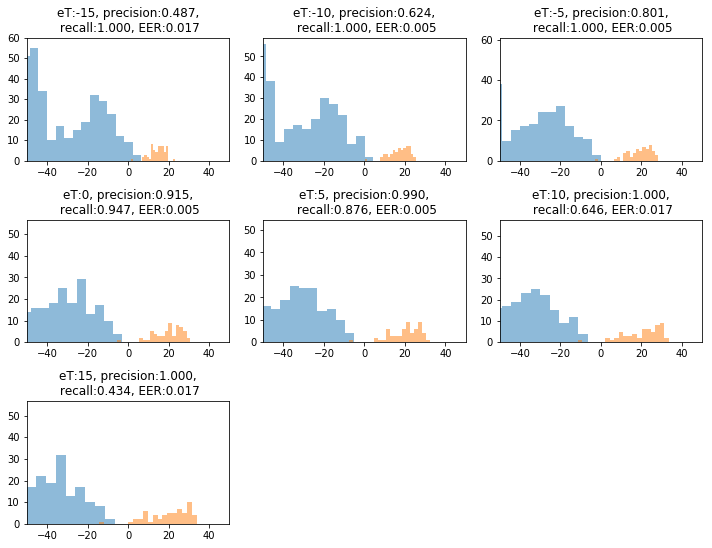

In [422]:
print("adapt_len:{}".format(adapt_len))
fig = plt.figure(figsize(10,10))
for i, eT in enumerate(eT_list): 
    plt.subplot(4, 3, i+1)
    adapt_idx = adapt_scores.mean(0)>eT
    precision, recall, _, _ = precision_recall_fscore_support(adapt_trial[1], adapt_idx, average='binary')
    _, counts = np.unique(adapt_trial[1][adapt_idx], return_counts=True)
    eer = compute_eer(multiSess_scale[eT], test_trial[1], verbose=False)[0]
    plt.xlim([-50, 50])
    plt.hist(multiSess_scale[eT][test_trial[1]==0], alpha=0.5, bins=20)
    plt.hist(multiSess_scale[eT][test_trial[1]==1], alpha=0.5, bins=20)
    plt.title("eT:{}, precision:{:.3f},\n recall:{:.3f}, EER:{:.3f}".format(eT, precision, recall, eer))
plt.tight_layout()
plt.show()

adapt_len:800


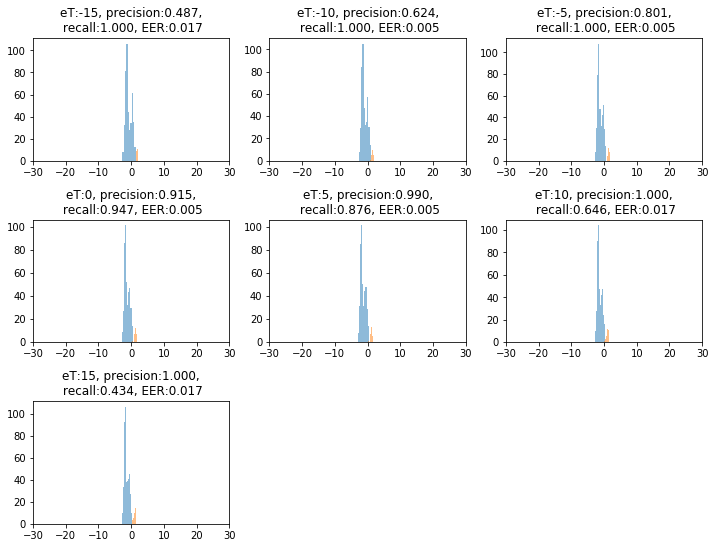

In [417]:
print("adapt_len:{}".format(adapt_len))
fig = plt.figure(figsize(10,10))
for i, eT in enumerate(eT_list): 
    plt.subplot(4, 3, i+1)
    adapt_idx = adapt_scores.mean(0)>eT
    precision, recall, _, _ = precision_recall_fscore_support(adapt_trial[1], adapt_idx, average='binary')
    _, counts = np.unique(adapt_trial[1][adapt_idx], return_counts=True)
    eer = compute_eer(multiSess_scale[eT], test_trial[1], verbose=False)[0]
    plt.xlim([-30, 30])
    plt.hist(multiSess_scale[eT][test_trial[1]==0], alpha=0.5, bins=10)
    plt.hist(multiSess_scale[eT][test_trial[1]==1], alpha=0.5, bins=10)
    plt.title("eT:{}, precision:{:.3f},\n recall:{:.3f}, EER:{:.3f}".format(eT, precision, recall, eer))
plt.tight_layout()
plt.show()

## Progressive adaptation 

In [383]:
t_i = 81
enr_spk, enr_ids, test_trial = trials[t_i]
# imposters = test_trial.spk.value_counts()[:10].index
# test_trial = test_trial[test_trial.spk.isin(imposters)]
test_trial = (np.array(test_trial.id), np.array(test_trial.label))

adapt_len = 1000
test_len = 500
assert adapt_len+test_len <= len(test_trial[0])
adapt_trial = (test_trial[0][:adapt_len], test_trial[1][:adapt_len])
test_trial = (test_trial[0][-test_len:], test_trial[1][-test_len:])

init_enr_embeds = get_embeds(enr_ids, sv_embeds, sv_id2idx, norm=False)
adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)

adapt_scores = py_plda_model.multi_sess(init_enr_embeds, adapt_embeds, cov_scaling=True).mean(0)

In [388]:
adapt_idx = np.nonzero(adapt_scores > -10)[0]
adapt_confids = adapt_scores[adapt_idx]
confid_sort_idx = np.flip(np.argsort(adapt_confids))

In [389]:
adapted_embeds = adapt_embeds[adapt_idx][confid_sort_idx]
adapt_labels = adapt_trial[1][adapt_idx][confid_sort_idx]

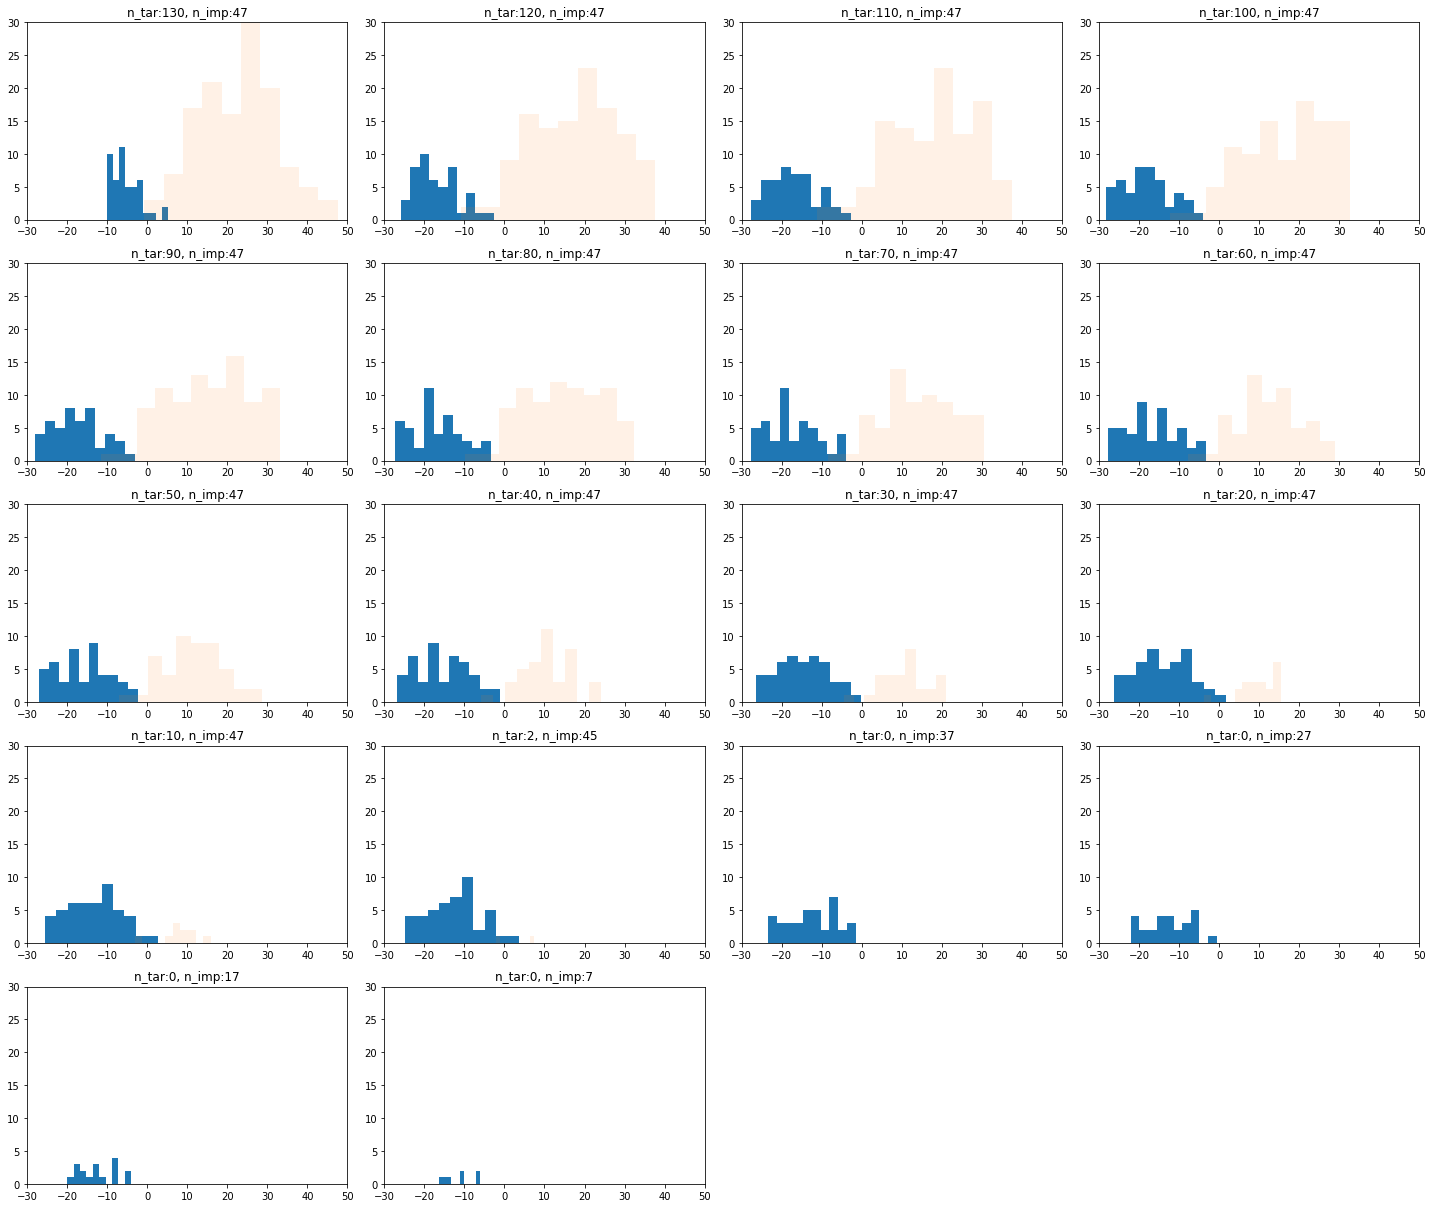

In [402]:
fig = plt.figure(figsize(20,20))
score_records = []
for j, i in enumerate(range(0, len(adapted_embeds), 10)):
    enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds[:i]])
    scores = py_plda_model.multi_sess(enr_embeds, adapted_embeds, cov_scaling=True).mean(0)
    score_records.append(scores)
    plt.subplot(6, 4, j+1)
    plt.xlim([-30, 50])
    plt.ylim([0, 30])
    plt.hist(scores[i:][adapt_labels[i:]==0], alpha=1, bins=10)
    plt.hist(scores[i:][adapt_labels[i:]==1], alpha=0.1, bins=10)
    plt.title("n_tar:{}, n_imp:{}".format(adapt_labels[i:].sum(), (1-adapt_labels[i:]).sum()))
plt.tight_layout()
plt.show()

In [403]:
score_moment = score_records[-1] - score_records[0]

In [404]:
score_moment[adapt_labels==0]

array([ -4.34627,  -3.60308,   3.78436,  -2.00336,  -0.44889,   5.00269,
         4.21291,  -3.68338,  10.4395 ,  -7.67206,  -2.73928,   6.03743,
         4.54607,   0.95187,   3.80849,   1.26934,   2.23442,   2.02406,
        -1.36405,  -3.69339,   1.93456,   2.30441,   2.87625,   8.13583,
        -2.27516, -11.23038,  -2.81119,  -1.6925 ,  -4.73745,  -0.84766,
         4.63071,   1.70332,  -2.80464,  -1.11124,  -6.07756,   2.22077,
        -8.7345 ,   7.27274,  -6.32549,  -7.0136 ,   2.17831,  -1.80983,
        -4.21392,  -7.21533,  -1.48483,  -4.77596,   3.95347])

In [405]:
score_moment[adapt_labels==1]

array([-22.95057, -24.32504, -12.75646,  -6.37695, -14.28365, -13.44139,
       -10.6317 ,  -7.99426,  -9.78013,  -6.58446,  -7.72046,  -8.41766,
        -4.27071,  -8.09571,  -0.84465,  -7.00219,  -0.40424,  -8.43682,
         1.81804,  -0.16258,  -6.46008,  -7.73748,  -3.03572,   0.79493,
        -1.56809,  -4.88328,  -6.38654,  -4.75629,  -2.84941,  -1.55889,
        -0.55418,  -2.02034,  -9.72294,   2.5636 ,  -2.2364 ,   1.07456,
        -1.54287,  -0.75787,  -7.93422,   1.39386,  -0.96645,   3.57064,
         5.24097,  -3.63881,  -4.47275,   1.50763,  -3.27505,  -3.83452,
         1.62145,   3.72286,   4.51875,   1.09004,  -1.22823,  -1.81077,
         3.18966,  -6.84934,   0.39553,   1.31799,  -0.90905,   1.02394,
        -2.10788,   4.99829,   2.40439,   1.542  ,   1.69314,   4.12307,
         3.9699 ,   6.18697,  -1.64262,  -1.42842,  -2.69583,   3.64484,
         2.18591,  -5.68142,  -5.84244,   1.04712,   3.31597,   4.56402,
        -2.90364,   4.06015,   6.66092,   8.2149 , 

## Score sorted adaptation 

In [223]:
t_i = 17
enr_spk, enr_ids, test_trial = trials[t_i]
# imposters = test_trial.spk.value_counts()[:10].index
# test_trial = test_trial[test_trial.spk.isin(imposters)]
test_trial = (np.array(test_trial.id), np.array(test_trial.label))

adapt_len = 800
adapt_trial = (test_trial[0][:adapt_len], test_trial[1][:adapt_len])
test_trial = (test_trial[0][adapt_len:], test_trial[1][adapt_len:])

init_enr_embeds = get_embeds(enr_ids, sv_embeds, sv_id2idx, norm=False)
adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)

true_adapt_embeds = adapt_embeds[adapt_trial[1]==1]
adapt_scores = py_plda_model.score_avg(init_enr_embeds, true_adapt_embeds).mean(0)
# adapt_scores = -np.linalg.norm(init_enr_embeds.mean(0,keepdims=True)-true_adapt_embeds, axis=1)
sorted_adapt_scores = np.sort(adapt_scores)
adapt_idx = np.argsort(adapt_scores)

for i in range(0, len(adapt_idx), 10): 
    adapt_score_mean = sorted_adapt_scores[i:i+10].mean(0)
    adapted_embeds = true_adapt_embeds[adapt_idx[i:i+10]]
    total_enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
    multiSess_scale = py_plda_model.multi_sess(total_enr_embeds, test_embeds, n_enr=None,
                                               cov_scaling=True, cov_adapt=False).mean(0)
    print("average adapt_confids: {:.3f}".format(adapt_score_mean))
    compute_eer(multiSess_scale, test_trial[1])
    print()

average adapt_confids: -6.147
eer: 0.47%, fpr: 0.47%, fnr: 0.00%

average adapt_confids: -2.903
eer: 2.56%, fpr: 1.90%, fnr: 2.56%

average adapt_confids: -1.467
eer: 0.95%, fpr: 0.95%, fnr: 0.00%

average adapt_confids: 0.066
eer: 1.42%, fpr: 1.42%, fnr: 0.00%

average adapt_confids: 1.461
eer: 2.56%, fpr: 1.42%, fnr: 2.56%

average adapt_confids: 2.565
eer: 2.56%, fpr: 1.90%, fnr: 2.56%

average adapt_confids: 3.691
eer: 0.95%, fpr: 0.95%, fnr: 0.00%

average adapt_confids: 4.721
eer: 0.95%, fpr: 0.95%, fnr: 0.00%

average adapt_confids: 5.665
eer: 0.95%, fpr: 0.95%, fnr: 0.00%

average adapt_confids: 7.141
eer: 0.95%, fpr: 0.95%, fnr: 0.00%

average adapt_confids: 8.432
eer: 2.56%, fpr: 1.42%, fnr: 2.56%

average adapt_confids: 9.406
eer: 0.95%, fpr: 0.95%, fnr: 0.00%

average adapt_confids: 18.072
eer: 2.56%, fpr: 2.37%, fnr: 2.56%



## Varying n_adapt 

In [ ]:
from ioffe_plda.verifier import Verifier
py_plda_model = Verifier(pickle.load(open("py_plda_model_ln_lda.pkl", "rb")))

In [ ]:
t_i = 0
enr_spk, enr_ids, test_trial = trials[t_i]
# imposters = test_trial.spk.value_counts()[:10].index
# test_trial = test_trial[test_trial.spk.isin(imposters)]
test_trial = (np.array(test_trial.id), np.array(test_trial.label))

adapt_len = 1000
adapt_trial = (test_trial[0][:adapt_len], test_trial[1][:adapt_len])
test_trial = (test_trial[0][adapt_len:], test_trial[1][adapt_len:])

init_enr_embeds = get_embeds(enr_ids, sv_embeds, sv_id2idx, norm=False)
adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)

eT = 5
adapt_scores = py_plda_model.score_avg(init_enr_embeds, adapt_embeds)
adapt_idx = np.nonzero(adapt_scores.mean(0) > eT)[0]

In [ ]:
multiSess = dict()

for n_adapt in range(0, len(adapt_idx)+1, 5):
    adapted_embeds = adapt_embeds[adapt_idx[:n_adapt]]
    total_enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
    multiSess[n_adapt] = py_plda_model.multi_sess(total_enr_embeds, test_embeds, 
                                         cov_scaling=True, cov_adapt=False).mean(0)

fig = plt.figure(figsize(10,10))
for i, (k, v) in enumerate(multiSess.items()):
    plt.subplot(np.ceil(len(multiSess)/4), 4, i+1)
    plt.xlim([-50, 50])
    plt.hist(v[test_trial[1]==0], alpha=0.5)
    plt.hist(v[test_trial[1]==1], alpha=0.5)
    eer = compute_eer(v, test_trial[1], verbose=False)[0]
    adapt_acc = np.mean(adapt_trial[1][adapt_idx[:k]])
    plt.title("N:{}[{:.1f}%], EER:{:.2f}%".format(k, adapt_acc*100, eer*100))
fig.suptitle("multiSess, cov_scale, scoreAvg_adapt", y=1.0)
plt.tight_layout()
plt.show()

In [ ]:
multiSess = dict()

for n_adapt in range(0, len(adapt_idx)+1, 2):
    adapted_embeds = adapt_embeds[adapt_idx[:n_adapt]]
    total_enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
    multiSess[n_adapt] = py_plda_model.multi_sess(total_enr_embeds, test_embeds, 
                                         cov_scaling=False, cov_adapt=True).mean(0)
    
fig = plt.figure(figsize(10,10))
for i, (k, v) in enumerate(multiSess.items()):
    plt.subplot(np.ceil(len(multiSess)/4), 4, i+1)
    plt.xlim([-50, 50])
    plt.hist(v[test_trial[1]==0], alpha=0.5)
    plt.hist(v[test_trial[1]==1], alpha=0.5)
    eer = compute_eer(v, test_trial[1], verbose=False)[0]
    adapt_acc = np.mean(adapt_trial[1][adapt_idx[:k]])
    plt.title("N:{}[{:.1f}%], EER:{:.2f}%".format(k, adapt_acc*100, eer*100))
fig.suptitle("multiSess, cov_adapt", y=1.0)
plt.tight_layout()
plt.show()

In [ ]:
scoreAvg = dict()

adapted_embeds = adapt_embeds[adapt_idx]
total_enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
scoreAvg_tot_scores = py_plda_model.score_avg(total_enr_embeds, test_embeds)

for n_adapt in range(0, len(total_enr_embeds)-3, 5):
    scoreAvg[n_adapt] = scoreAvg_tot_scores[:3+n_adapt].mean(0)
    
fig = plt.figure(figsize(10,10))
for i, (k, v) in enumerate(scoreAvg.items()):
    plt.subplot(np.ceil(len(scoreAvg)/4), 4, i+1)
    plt.xlim([-50, 50])
    plt.hist(v[test_trial[1]==0], alpha=0.5)
    plt.hist(v[test_trial[1]==1], alpha=0.5)
    eer = compute_eer(v, test_trial[1], verbose=False)[0]
    adapt_acc = np.mean(adapt_trial[1][adapt_idx[:k]])
    plt.title("N:{}[{:.1f}%], EER:{:.2f}%".format(k, adapt_acc*100, eer*100))
plt.tight_layout()
plt.show()

## Precision/Recall impact 

In [ ]:
from tqdm import tqdm 

eT_list =  [-15, -10, -5, 0, 5, 10, 15]
multiSess_scale = {k:[] for k in eT_list}
multiSess_adapt = {k:[] for k in eT_list}
adapt_preds = {k:[] for k in eT_list}

multiSess_opt = []
multiSess_init = []
adapt_label_list = []
label_list = []
# t_end = len(trials)
t_end = 50
t_st = 1
f_norm = False

for i, t_i in tqdm(enumerate(range(0, t_end, t_st)), total=t_end//t_st):
    enr_spk, enr_ids, test_trial = trials[t_i]
    test_trial = (np.array(test_trial.id), np.array(test_trial.label))

    adapt_len = 500
    adapt_trial = (test_trial[0][:adapt_len], test_trial[1][:adapt_len])
    test_trial = (test_trial[0][adapt_len:], test_trial[1][adapt_len:])
    
    adapt_label_list.append(adapt_trial[1])
    label_list.append(test_trial[1])
    
    init_enr_embeds = get_embeds(enr_ids, sv_embeds,  sv_id2idx, norm=False)
    adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
    test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)
    
    adapt_scores = py_plda_model.score_avg(init_enr_embeds, adapt_embeds)
    
    optimal_enr_embeds = np.concatenate([init_enr_embeds, adapt_embeds[adapt_trial[1]==1]])
    multiSess_opt.append(py_plda_model.multi_sess(optimal_enr_embeds, test_embeds,
                                                 cov_scaling=True, cov_adapt=False).mean(0))
    multiSess_init.append(py_plda_model.multi_sess(init_enr_embeds, test_embeds,
                                                 cov_scaling=True, cov_adapt=False).mean(0))
    
    for eT in eT_list:
        # adaptation
        adapted_embeds = adapt_embeds[adapt_scores.mean(0) > eT]
        adapt_preds[eT].append(adapt_scores.mean(0) > eT)

        # test
        total_enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
        multiSess_scale_scores = py_plda_model.multi_sess(total_enr_embeds, test_embeds,
                                                          cov_scaling=True, cov_adapt=False).mean(0)
        
        if f_norm and len(adapted_embeds) > 0:
            a = 1
            client_scores = py_plda_model.score_avg(init_enr_embeds, adapted_embeds).mean(0)
            client_mean = client_scores.mean()
            imp_scores = py_plda_model.score_avg(init_enr_embeds, cohort_embeds).mean(0)
            imp_mean = imp_scores.mean()
            multiSess_scale_scores = (multiSess_scale_scores-imp_mean)*(2*a/(client_mean - imp_mean)) - a
            
        multiSess_scale[eT].append(multiSess_scale_scores) 
                                   
#         multiSess_adapt[eT].append(py_plda_model.multi_sess(total_enr_embeds, test_embeds, 
#                                              cov_scaling=False, cov_adapt=True).mean(0))


In [ ]:
np.mean(adapt_trial[1])

In [ ]:
print("init")
compute_eer(np.concatenate(multiSess_init), np.concatenate(label_list))

In [ ]:
print("optimal")
compute_eer(np.concatenate(multiSess_opt), np.concatenate(label_list))

In [ ]:
for eT in eT_list:
    precision, recall, _, _ = precision_recall_fscore_support(np.concatenate(adapt_label_list), np.concatenate(adapt_preds[eT]), average='binary')
    print("eT:{}, precision:{:.3f}, recall:{:.3f}".format(eT, precision, recall))
    compute_eer(np.concatenate(multiSess_scale[eT]), np.concatenate(label_list))
#     compute_eer(np.concatenate(multiSess_adapt[eT]), np.concatenate(label_list))
    print()

In [ ]:
for eT in eT_list:
    precision, recall, _, _ = precision_recall_fscore_support(np.concatenate(adapt_label_list), np.concatenate(adapt_preds[eT]), average='binary')
    print("eT:{}, precision:{:.3f}, recall:{:.3f}".format(eT, precision, recall))
    compute_eer(np.concatenate(multiSess_scale[eT]), np.concatenate(label_list))
#     compute_eer(np.concatenate(multiSess_adapt[eT]), np.concatenate(label_list))
    print()

In [ ]:
for t_i in range(len(label_list)):
    for eT in eT_list:
        precision, recall, _, _ = precision_recall_fscore_support(adapt_label_list[t_i], 
                                                                  adapt_preds[eT][t_i], average='binary')
        print("eT:{}, precision:{:.3f}, recall:{:.3f}, n_adapt:{}".format(
            eT, precision, recall, np.sum(adapt_preds[eT][t_i])))
        compute_eer(multiSess_scale[eT][t_i], label_list[t_i])
        #     compute_eer(np.concatenate(multiSess_adapt[eT]), np.concatenate(label_list))
    print()

In [ ]:
multiSess_scale[eT][t_i]

In [ ]:
auc = roc_auc_score(adapt_trial[1], adapt_scores.mean(0))
ap = average_precision_score(adapt_trial[1], adapt_scores.mean(0))
print("AUC:{:.2f}, AP:{:.2f}".format(auc, ap))

In [ ]:
# F-norm

client_scores = py_plda_model.score_avg(init_enr_embeds, init_enr_embeds)
client_mean = np.triu(client_scores, 1).mean()

cohort_ids = np.load("trials/dev940_eval311/dev_cohort_ids.npy")
cohort_embeds = get_embeds(cohort_ids, sv_embeds, sv_id2idx, norm=False)
imp_scores = py_plda_model.score_avg(init_enr_embeds, cohort_embeds).mean(0)
imp_mean = imp_scores.mean()

a = 1
f_scores = (adapt_scores-imp_mean)*(2*a/(client_mean - imp_mean)) - a

In [ ]:
adapt_eT = 10
f_adapt_preds = f_scores.mean(0) > 0.5
f_adapt_idx = np.nonzero(f_adapt_preds)[0]
adapt_preds = adapt_scores.mean(0) > adapt_eT
adapt_idx = np.nonzero(adapt_preds)[0]

### LR model score 

In [ ]:
tr_idx = 450
tr_score_avg = np.concatenate([s.mean(0) for s in scoreAvg[:tr_idx]])
tr_score_std = np.concatenate([s.std(0) for s in scoreAvg[:tr_idx]])
tr_score_max = np.concatenate([s.max(0) for s in scoreAvg[:tr_idx]])
tr_labels = np.concatenate(labels[:tr_idx])
tr_feat = np.stack([tr_score_avg, tr_score_std, tr_score_max], axis=1) 

te_score_avg = np.concatenate([s.mean(0) for s in scoreAvg[tr_idx:]])
te_score_std = np.concatenate([s.std(0) for s in scoreAvg[tr_idx:]])
te_score_max = np.concatenate([s.max(0) for s in scoreAvg[tr_idx:]])
te_labels = np.concatenate(labels[tr_idx:])
te_feat = np.stack([te_score_avg, te_score_std, te_score_max], axis=1) 

# LR train
from sklearn.linear_model import LogisticRegressionCV

lr_clf = LogisticRegressionCV(Cs=10, fit_intercept=True, class_weight='balanced')
lr_clf.fit(tr_feat, tr_labels)

In [ ]:
score_feat = lr_clf.decision_function(te_feat)
compute_eer(score_feat, te_labels);

In [ ]:
compute_eer(te_score_avg, te_labels);